## Settings

In [1]:
from pathlib import Path
import importlib
from functools import partial

from skimage import color
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns
from bruno_util import plotting as bplt
import scipy
import scipy.stats
from PIL import Image

import multi_locus_analysis as mla
import multi_locus_analysis.examples.burgess as burgess
from multi_locus_analysis.examples.burgess.plotting import *

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Defaults

In [2]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

### PNAS
global settings and information about PNAS journal format

In [19]:
col_width = 3.405  # in, size of figure width=\columnwidth
true_col_width = 3.463  # in, size of example column of text
text_width = 6.998  # in, size of figure* width=\textwidth
true_text_width = 7.024  # in, size of two example columns together
content_width = 7.518  # in, including line numbers, etc
page_width = 8.5  # 8.5 x 11in format
golden_ratio = (1 + np.sqrt(5))/2
mpl.rcParams['font.size'] = 8.0  # PNAS declares 9pt default text but uses ~8pt, with ~6pt captions
mpl.rcParams['xtick.labelsize'] = 'medium'  # default : medium
mpl.rcParams['ytick.labelsize'] = 'medium'  #
mpl.rcParams['axes.titlesize'] = 'x-large'  # default : large, 
mpl.rcParams['axes.labelsize'] = 'large'  # default : medium
mpl.rcParams['text.usetex'] = True

### Color Map

Pick three colors (a blue, a green and a red) to stand for "early", "middle", and "late". Then in L*a*b space, use a sawtooth in L to emphasize (in dark) the three colors, while moving in a straight line between them.

We should probably be using "colorspacious" and "viscm" instead, which is how they designed viridis, and uses a more up-to-date color space CAM02-UCS (which is a euclideanization of CIECAM02).

In [167]:
vmax_long = 5.7
vmax_light = 5.0
vmax_sim = 7.5
total_colors = 5000

grey = np.array([100/255, 100/255, 100/255])
three_colors = [[ 56/255   , 125/255   , 156/255  ], 
                [ 63/255   , 138/255   ,  92/255  ], 
                [163/255   , 85/255    , 153/255  ]]
# #                 [166/255   , 58/255    , 133/255  ]]
# need to add a dim, since skimage expects >=2d images
lab_colors = color.rgb2lab(np.array([three_colors]), illuminant='D65', observer='2')[0]

def bruno_div_map(n, left_lab, right_lab, midpoint_l, target_l=None):
    l, a, b = 0, 1, 2
    left_l = left_lab[l] if target_l is None else target_l
    right_l = right_lab[l] if target_l is None else target_l
    t = np.linspace(0, 1, n)
    lab_a = np.interp(t, [0, 1], [left_lab[a], right_lab[a]])
    lab_b = np.interp(t, [0, 1], [left_lab[b], right_lab[b]])
    lab_l = np.interp(t, [0, 1/2, 1], [left_l, midpoint_l, right_l])
    return list(zip(lab_l, lab_a, lab_b))

# artificially place the sawtooth peak at T=3.5 to highlight "mid-prophase", 
# but also cause the "0.5" extra makes teh post-discretized colors look nice
num_grey = int(((0 - (-1))/(vmax_long - (-1))) * total_colors) - 1
num_left = int(((3.5 - 0)/(vmax_long - (-1))) * total_colors)
num_right = int(((vmax_long - 3.5)/(vmax_long - (-1))) * total_colors)

blended_divs = np.concatenate((
    bruno_div_map(num_left, lab_colors[0], lab_colors[1], midpoint_l=80, target_l=50),
    bruno_div_map(num_right, lab_colors[1], lab_colors[2], midpoint_l=80, target_l=50)[1:]
))
# need to add a dim, since skimage expects >=2d images
bgr_long = color.lab2rgb(np.array([blended_divs]), illuminant='D65', observer='2')[0]
bgr_long = np.concatenate((np.tile(grey, (num_grey, 1)), bgr_long))

num_grey = int(((0 - (-1))/(vmax_light - (-1))) * total_colors) - 1
num_left = int(((3 - 0)/(vmax_light - (-1))) * total_colors)
num_right = int(((vmax_light - 3)/(vmax_light - (-1))) * total_colors)

blended_divs_light = np.concatenate((
    bruno_div_map(num_left, lab_colors[0], lab_colors[1], midpoint_l=80, target_l=50),
    bruno_div_map(num_right, lab_colors[1], lab_colors[2], midpoint_l=80, target_l=50)[1:]
))
# need to add a dim, since skimage expects >=2d images
bgr_light = color.lab2rgb(np.array([blended_divs_light]), illuminant='D65', observer='2')[0]
bgr_light = np.concatenate((np.tile(grey, (num_grey, 1)), bgr_light))

# Co-authors want a separate, linear cmap
# num_left = int((4 - 1)/(vmax_sim - 1) * total_colors)
# num_right = int((vmax_sim - 4)/(vmax_sim - 1) * total_colors)
# blended_divs_sim = np.concatenate((
#     bruno_div_map(num_left, lab_colors[0], lab_colors[1], midpoint_l=80, target_l=50),
#     bruno_div_map(num_right, lab_colors[1], lab_colors[2], midpoint_l=80, target_l=50)[1:]
# ))
# # need to add a dim, since skimage expects >=2d images
# bgr_sim = color.lab2rgb(np.array([blended_divs_sim]), illuminant='D65', observer='2')[0]
sim_cmap = mpl.cm.winter

cmap_long = mpl.colors.ListedColormap(bgr_long)
cmap_light = mpl.colors.ListedColormap(bgr_light)
# sim_cmap = mpl.colors.ListedColormap(bgr_dark)
# sim_cmap = mpl.colors.ListedColormap(bgr_sim)


# discretize the continuous norm to integers in the relevant range
long_labels = np.arange(-1, np.ceil(vmax_long) + 1)
long_cbounds = np.arange(-1.5, np.ceil(vmax_long) + 1.5)
# continuous norm, to be replaced once we extract out the discrete colors
long_cnorm_continuous = mpl.colors.Normalize(vmin=-1, vmax=vmax_long)
long_colors = cmap_long(long_cnorm_continuous(long_labels))
long_cnorm = mpl.colors.BoundaryNorm(long_cbounds, len(long_labels))
long_listed_cmap = mpl.colors.ListedColormap(long_colors)
long_sm = mpl.cm.ScalarMappable(norm=long_cnorm, cmap=long_listed_cmap)
long_sm.set_array([])
long_locator = ticker.MultipleLocator(1)
long_formatter = ticker.FuncFormatter(lambda i, _: f'$T_{i}$' if i >= 0 else '$G_0$')
long_sm_continuous = mpl.cm.ScalarMappable(norm=long_cnorm_continuous, cmap=cmap_long)
long_sm_continuous.set_array([])

sim_labels = np.arange(1, vmax_sim + 1)
sim_cbounds = np.arange(0.5, vmax_sim + 1.5)
# sim_cbounds[0] = 1
sim_cnorm_continuous = mpl.colors.Normalize(vmin=1, vmax=vmax_sim)
sim_colors = sim_cmap(sim_cnorm_continuous(sim_labels))
sim_cnorm = mpl.colors.BoundaryNorm(sim_cbounds, len(sim_labels))
sim_listed_cmap = mpl.colors.ListedColormap(sim_colors)
sim_locator = ticker.MultipleLocator(1)
sim_sm = mpl.cm.ScalarMappable(norm=sim_cnorm, cmap=sim_listed_cmap)
sim_sm.set_array([])
sim_sm_continuous = mpl.cm.ScalarMappable(norm=sim_cnorm_continuous, cmap=sim_cmap)
sim_sm_continuous.set_array([])

# Ignore for now, see what breaks.
# cnorm_light = mpl.colors.Normalize(vmin=-1, vmax=vmax_light)
# # scalar mappables are just norm/cmap pairs
# meiosis_sm_light = mpl.cm.ScalarMappable(norm=cnorm_light, cmap=cmap_light)
# meiosis_sm_light.set_array([])

cycling_cmap = plt.get_cmap("tab10")

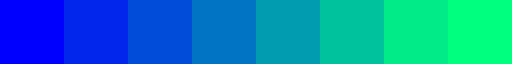

In [168]:
sim_listed_cmap

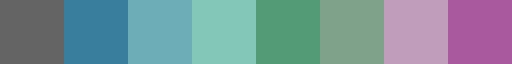

In [6]:
long_listed_cmap

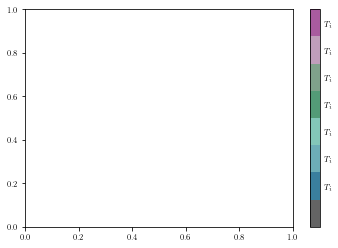

In [38]:
cbar = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
cbar.ax.tick_params(length=0)

### Useful functions

In [52]:
def plot_fracs_small(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 4  # if strain == 'LYS2' else 4
            markeredgewidth = 1.5 if strain == 'LYS2' else 1
            
            if ax is None:
                ax = plt
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=1, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  
    
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = cycling_cmap(1) if genotype == 'WT' else cycling_cmap(0)
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 8  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            
            if ax is None:
                ax = plt
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, #fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chronological stage')
    ax.xaxis.set_major_locator(long_locator)
    ax.xaxis.set_major_formatter(long_formatter)
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  

## Figure 1

In [65]:
# ### PANEL A
# def fig1a(ax1a):
#     im = Image.open("extracted-progression-diagram.png")
#     ax1a.imshow(im)
#     ax1a.axis('off')
#     ax1a.text(0.270, 1, "Early", fontsize=mpl.rcParams['axes.titlesize'], color=color_early, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.577, 1, "Mid", fontsize=mpl.rcParams['axes.titlesize'], color=color_mid, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     ax1a.text(0.892, 1, "Late", fontsize=mpl.rcParams['axes.titlesize'], color=color_late, fontweight='bold', ha='center', va='bottom', transform=ax1a.transAxes)
#     return ax1a

### PANEL B

def fig1b(ax1b):
    # make background image with various colors
    color_list = cmap_long(long_cnorm_continuous(np.linspace(0, 5, 1000)))
    color_list[:,3] = 0.9 # alpha value
    background_img = np.tile(color_list, (2, 1, 1)).T.T

    # get data about meiotic progression extracted from Trent's figure
    df_trent = pd.read_csv('pnas_data/extracted-progression-data.csv')
    t04 = np.arange(0, 5)
    frac_nuc = df_trent['Unnamed: 1'].iloc[1:].values.astype(float)
    t2p5 = np.arange(2.5, 5)
    frac_sc = df_trent['Unnamed: 3'].iloc[1:4].values.astype(float)
    t35 = np.arange(3, 6)
    frac_mi = df_trent['Unnamed: 5'].iloc[1:4].values.astype(float)
    # make lines
    ax1b.plot(t04, frac_nuc/100, c='k', marker='o', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
    ax1b.plot(t2p5, frac_sc/100, c='k', marker='X', markersize=8, markeredgewidth=1,
             fillstyle='full', linestyle='-', lw=1.5, clip_on=False)
    ax1b.plot(t35, frac_mi/100, c='k', marker='s', markersize=8, markeredgewidth=2,
             fillstyle='full', markerfacecolor='white', linestyle='-', lw=1.5, clip_on=False)
    # make text overlay
    dna_rep_time = [0.3, 1.5]
    dna_rep_y = 0.775
    dna_rep_cap_width = 0.03
    dna_rep_cap_y = [dna_rep_y - dna_rep_cap_width, dna_rep_y + dna_rep_cap_width]
    ax1b.plot(dna_rep_time, [dna_rep_y, dna_rep_y], color='k', linestyle='-', lw=1.5)
    ax1b.plot([dna_rep_time[0], dna_rep_time[0]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
    ax1b.plot([dna_rep_time[1], dna_rep_time[1]], dna_rep_cap_y, color='k', linestyle='-', lw=1.5)
    ax1b.text(np.mean(dna_rep_time)+0.02, 0.84, 'DNA Rep', ha='center', va='bottom')
    ax1b.text(2.4, 0.68, 'Colocalization', ha='center', va='top')
    ax1b.text(2.7, 0.36, 'SC', ha='center', va='top')
    ax1b.text(4.52, 0.2, 'MI', ha='center', va='top')

    ax1b.imshow(background_img, extent=[0, 5, 0, 1], aspect='auto')
    ax1b.set_xlim([0, 5])
    ax1b.set_ylim([0, 1])

    ax1b.set_xlabel('Chron. stage ($t_\#$)')
    ax1b.set_ylabel('Probability')
    ax1b.set_title('Meiotic prophase')
    return ax1b


take out SC curve, add description stating that before t3, no division occurs.

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

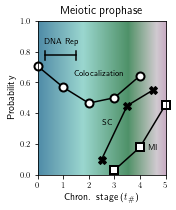

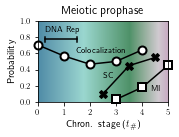

In [66]:
fig1bh, fig1b_height = bplt.make_at_aspect([fig1b], [1/golden_ratio], col_width=2.295)
plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-09-15-full-remake/Figure1b.pdf', dpi=500)
plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-09-15-full-remake/Figure1b.svg', dpi=500)

## Figure 2

Made fully in Inkscape.... :/

## Figure 3

Made fully in Inkscape.... :/

## Figure 4

In [99]:
def fig3a(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
#     plt.title('Per-Cell MSCDs for Condition: (URA3, WT, t3)')
    ax.set_prop_cycle(color=['#aec7e8'])
    cell_ids = []
    for i, (cell_id, data) in enumerate(free_mscds3.groupby(['exp.rep', 'cell'])):
    #     if i not in [10, 25, 30, 60]: # 60 is flat
        if i % 20 != 0:
                continue
        cell_ids.append(cell_id)
        data = data.reset_index()
        data = data[(data['delta'] > 0) & (data['mean'] > 0)]
        data = data.sort_values('delta')
    #     plt.errorbar(data['delta'], data['mean'], data['ste'])
        if cell_id == (5, 56):
            plt.plot(data['delta'], data['mean'], '-', c='#1f77b4', lw=5, zorder=3)
        else:
            plt.plot(data['delta'], data['mean'], alpha=1, lw=1)
            plt.plot(data['delta'], data['mean'], alpha=0.3, lw=3)
    bplt.draw_power_law_triangle(alpha=0, x0=[30, 1.05], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
    bplt.draw_power_law_triangle(alpha=0.5, x0=[225, 0.37], width=0.7, 
                                 label_padding=0.05,
                                 orientation='down', x0_logscale=False, 
                                 label=r'$\alpha=0.5$', lw=2, text_args={'backgroundcolor':[1,1,1,0.9]})
#     ax.set_ylim([0.2, 2.05])
    ax.set_ylim([0.2, 4])    
    ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3., 4.])
    ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", "", r"$4\times{}10^4$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

def fig3b(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10, 10**4])
    ax.set_ylim([0.2, 4])    
    ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3., 4.])
    ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", "", r"$4\times{}10^4$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    
    return ax

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

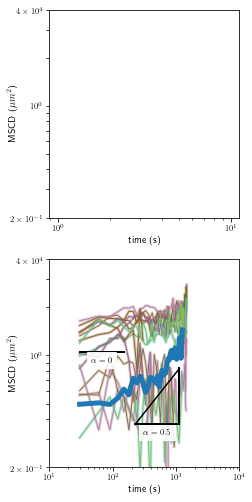

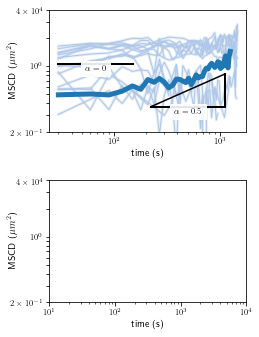

In [100]:
free_group3 = burgess.df_flat.loc['URA3', 'WT', :, 't3'].copy()

free_mscds3 = burgess.msds.msd(free_group3[free_group3['foci'] == 'unp'], mscd=True, include_z=True, 
                              traj_group=['exp.rep', 'cell'],
                              groups=['exp.rep', 'cell'])
fig3, fig3_heights = bplt.make_at_aspect([fig3a, fig3b], [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, is_ratio=True)

plt.savefig("/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-09-15-full-remake/Figure3a.pdf")
plt.savefig("/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-09-15-full-remake/Figure3a.svg")


# Figure 5

after running the following, they must still be assembled in inkscape and the labels of the arrows must still be added (by copying over the appropriate colorbar tick labels)

In [127]:
mscds.loc['URA3', 'SP'].groupby('meiosis').first()

,delta,mean,std,count,ste,ste_norm
meiosis,,,,,,
t0,0,0.0,0.0,4085,0.0,0.025887
t1,0,0.0,0.0,7648,0.0,0.037385
t2,0,0.0,0.0,5796,0.0,0.040068
t3,0,0.0,0.0,11253,0.0,0.039422
t4,0,0.0,0.0,9661,0.0,0.041240
t5,0,0.0,0.0,7915,0.0,0.040239
t6,0,0.0,0.0,1820,0.0,0.037431
ta,0,0.0,0.0,350,0.0,0.034299


In [136]:
andy_data = pd.read_csv('pnas_data/andy-plateaus.csv', header=None, index_col=0)[1]

In [142]:
andy_data[1:8].values

array([291.968, 282.759, 268.738, 249.069, 226.809, 208.373, 188.672])

In [153]:
andy_data['tick9']

306.091

In [152]:
m*andy_data['tick9'] + c

0.8999999999999999

In [149]:
x_coords, y_coords = ([andy_data['tick9'], andy_data['tick10']], [0.9, 1.0])
A = np.vstack([x_coords,np.ones(len(x_coords))]).T
m, c = np.linalg.lstsq(A, y_coords)[0]

<ipython-input-149-0de3abc8e4bf>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y_coords)[0]


In [160]:
andy_links = np.arange(1, 9)
andy_plats = np.power(10, m*andy_data[0:8].values + c - 1)

In [144]:
np.interp(andy_data[1:8].values, [andy_data['tick9'], andy_data['tick10']], [0.9, 1.0])

array([1. , 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

In [159]:
andy_data[0:8]

0
1    300.007
2    291.968
3    282.759
4    268.738
5    249.069
6    226.809
7    208.373
8    188.672
Name: 1, dtype: float64

In [131]:
locus = 'URA3'
strains_for_plateau = [(locus, 'WT'), (locus, 'SP')]
msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
        .set_index(['locus', 'genotype', 'meiosis'])
def average_end_times(df):
    return np.mean(df.loc[df['delta'] > 800, 'mean'])
plateaus = pd.DataFrame(index=[f't{i}' for i in range(7)])
for strain in strains_for_plateau:
    d = mscds.loc[strain]
    averages = d.groupby('meiosis').apply(average_end_times)
    plateaus[strain] = averages.loc['t0':'t6']

In [132]:
plateaus

,"(URA3, WT)","(URA3, SP)"
t0,0.906255,0.866363
t1,1.106019,1.020559
t2,1.276101,1.175226
t3,1.266145,1.303145
t4,1.173193,1.315637
t5,0.944171,1.135970
t6,NaN,1.280400


In [101]:
def fig4ac(ax, strain=('URA3', 'WT'), arrows=True):
    msds_file = burgess.burgess_dir / Path('msds_dvel_unp.csv')
    if not msds_file.exists():
        burgess.msds.precompute_msds()
    mscds = pd.read_csv(msds_file) \
            .set_index(['locus', 'genotype', 'meiosis'])

    d = mscds.loc[strain]

#     fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')

    ## draw all the MSCDs
    thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
    lines = {}
    for meiosis, data in d.groupby('meiosis'):
        t = -1 if meiosis[1] == 'a' else int(meiosis[1])
        data = data[data['delta'] > 0]
        zorder = 1.5 if t < 0 else 2  # 2 is default
        linewidth = 2 if t in thick_lines else 1
        alpha = 0.8 if t < 0 else 1
        lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
                                      c=long_listed_cmap(long_cnorm(t)), zorder=zorder,
                                      alpha=alpha, lw=linewidth)
    #     bplt.draw_power_law_triangle(alpha=0.2, x0=[100, 0.5], width=0.7, orientation='down', x0_logscale=False, label=r'$\alpha=0.2$', label_padding=0.02)
    ax.set_ylim([0.5, 1.5])
    ax.set_xlim(ax.get_xlim())  # default is good, but needs stay fixed

    ## draw the two arrows
    if arrows:
        # in data coordinates
        x1, y1 = 30, 0.61
        x2, y2 = 50, 1
        # in axes coordinates, to avoid bad log scaling
        data_to_ax = ax.transData + ax.transAxes.inverted()
        X1_ax = data_to_ax.transform([x1, y1])
        X2_ax = data_to_ax.transform([x2, y2])
        dX21_ax = X2_ax - X1_ax
        ax.arrow(*X1_ax, *dX21_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)
        X3_ax = X2_ax + np.array([0.05, 0.05])
        x4, y4 = 84, 0.9
        X4_ax = data_to_ax.transform([x4, y4])
        X4_ax_alt = X3_ax + dX21_ax*np.array([1, -1])  # to get same x offset
        dX43_ax = X4_ax - X3_ax
        ax.arrow(*X3_ax, *dX43_ax, transform=ax.transAxes, width=0.005,
                 length_includes_head=True, head_width=0.035, facecolor='k', 
                 zorder=4)

    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    # plt.savefig("/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-01-28-proposed/mscd-" + str(strain) + "-with-cbar-short.pdf")


    ## ticks, labels, etc
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$"])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

def fig4b(ax):
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    cb.set_label('Connections per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([10, 10**4])
    ax.set_ylim([0.5, 1.5])    
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])#, [r"$5\times{}10^{-1}$", "$10^0$"])
    ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times{}10^{0}$"])
#     ax.set_ylim([0.2, 3.5])
#     ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2., 3.])
#     ax.set_yticklabels([r"$2\times{}10^{-1}$", "", "", "", "","","","", "$10^0$", "", ""])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('MSCD ($\mu{}m^2$)', labelpad=-float(mpl.rcParams['font.size']))
    return ax

make two plots: 
1) as is, data
2) chronological stage vs num-linkages fit

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

(<Figure size 245.16x326.65 with 4 Axes>, array([1.74190934, 1.74190934]))

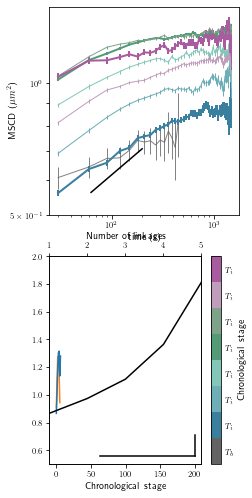

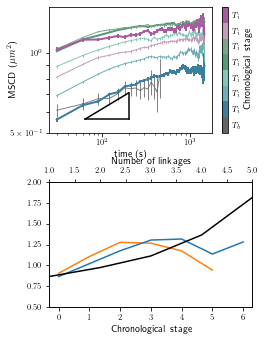

In [166]:
def fig4d(ax):
    wt = plateaus[(locus, 'WT')]
    sp = plateaus[(locus, 'SP')]
    ax.plot(np.arange(len(wt)), wt.values, c=cycling_cmap(1))
    ax.plot(np.arange(len(sp)), sp.values, c=cycling_cmap(0))
    ax.set_xlabel('Chronological stage')
    ax.set_ylim([0.5, 2])
    ax2 = ax.twiny()
    ax2.plot(andy_links, andy_plats, c='k')
    ax2.set_xlabel('Number of linkages')
    ax2.set_xlim([1, 5])
def fig4c_with_triangle(ax):
    fig4ac(ax, strain=('URA3', 'SP'), arrows=False)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
    
bplt.make_at_aspect(
        [fig4c_with_triangle, fig4d], 
        [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['min_axis_width', 'min_axis_width'],
        is_ratio=True)

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

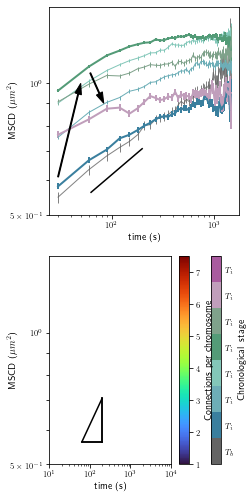

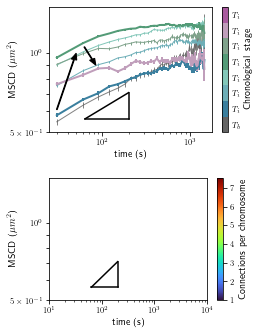

In [102]:
def fig4a_with_triangle(ax):
    fig4ac(ax, strain=('URA3', 'WT'))
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
def figb_with_triangle(ax):    
    fig4b(ax)
    bplt.draw_power_law_triangle(0.2, (1.8, -0.25), 0.5, orientation='down', ax=ax)
    return ax
bplt.make_at_aspect(
        [fig4a_with_triangle, figb_with_triangle], 
        [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-09-15-full-remake/Figure4ab_with_triangle.svg')

# Figure 6

In [103]:
def fig4d(ax):
    pair_fracs = (df_flat['foci'] == 'pair').groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
    cells_per_state = df_flat.reset_index().groupby(condition_cols)['cell'].unique().apply(len)
    pair_fracs['cell_count'] = cells_per_state
    plot_fracs_large(pair_fracs, ax)
    ax.set_ylabel('Fraction always colocalized')
    ax.legend(fontsize='small')
    return ax
  
def fig4e(ax):
    is_mixed = df_flat['foci'].groupby(burgess.cell_cols).apply(lambda x: np.any(x == 'pair') and np.any(x == 'unp'))
    mixed_fracs = is_mixed.groupby(burgess.condition_cols).agg(['mean', 'std', 'count'])
    cells_per_state = df_flat.reset_index().groupby(condition_cols)['cell'].unique().apply(len)
    mixed_fracs['cell_count'] = cells_per_state
    mixed_fracs['ste'] = mixed_fracs['std']/np.sqrt(mixed_fracs['cell_count'])
    plot_fracs_large(mixed_fracs, ax)
    ax.legend(fontsize='small')
    ax.set_ylabel('Fraction mixed')
    ax.set_ylim([0.15, 0.95])
    return ax
    
    

make symbols one size smaller

make G_0 separate line

/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

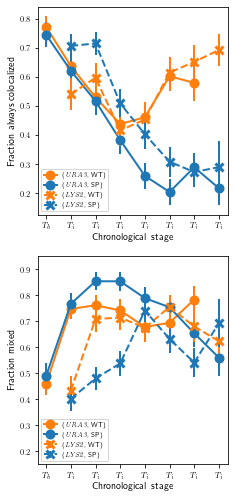

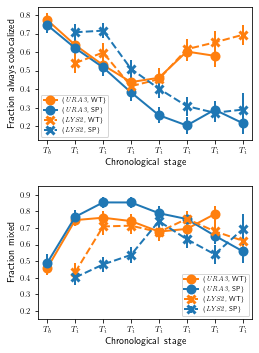

In [82]:
fig4de, fig4de_heights = bplt.make_at_aspect([fig4d, fig4e], [1/golden_ratio, 1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'min_axis_width'],
        is_ratio=True)
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-04-03-pnas/Figure4de.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-04-03-pnas/Figure4de.svg')

## Figure 7

TODO: fix line coloring and ordering, currently done in inkscape...

In [59]:
sim_df = pd.read_csv(burgess.burgess_dir / Path('pnas_data/df_exp.csv'))
sim_df['t'] = np.round(sim_df['t']/30).astype(int)*30
for x in ['X', 'Y', 'Z']:
    sim_df['d'+x] = sim_df[x+'2'] - sim_df[x+'1']
wait_sim = burgess.simulation.get_interior_times(sim_df)
wait_sim = wait_sim.reset_index()
# wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < 0.2)]
wait_sim = wait_sim[(wait_sim['FP'] > 0) & (wait_sim['FP'] < vmax_sim)]

waitdf = df_flat.groupby(burgess.cell_cols + ['na_id']).apply(mla.finite_window.discrete_trajectory_to_wait_times, t_col='t', state_col='foci')
waitdf.dropna(inplace=True) # get rid of NaN waits (currently buggy window sizes)
interior_df = waitdf.groupby(burgess.cell_cols + ['na_id']).apply(
    lambda df: df.iloc[1:-1].reset_index(level='rank_order').reset_index(drop=True).set_index('rank_order'))
interior_df.sort_index(inplace=True)
pair_df = interior_df[interior_df['wait_state'] == 'pair']
unpair_df = interior_df[interior_df['wait_state'] == 'unp']

In [104]:
def fig5abcd(ax, strain=('LYS2', 'WT'), pair='pair'):
    df = pair_df if pair == 'pair' else unpair_df
    state_waits = df.loc[strain]
    bold_lines = [0, 6] if 't6' in state_waits.reset_index()['meiosis'] else [0, 5]
    print(bold_lines)
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t in bold_lines:
            continue
        alpha = 0.5
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, alpha=alpha)
    # make sure bold lines are on top
    for m, data in state_waits.groupby('meiosis'):
        t = -1 if m[1] == 'a' else int(m[1])
        if t not in bold_lines:
            continue
        print(f'found bold line: {m}')
        pad = None if 0 in data['wait_time'].values else 0
        x, cdf = mla.finite_window.ecdf_windowed(data['wait_time'].values, data['window_size'].values, pad_left_at_x=pad)
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        color = long_listed_cmap(long_cnorm(t))
        ax.plot(xp, pdf, label=m, c=color, lw=2)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probability')
    ax.set_yscale('log')
    ax.set_xscale('log')
    pair = 'Residence times' if pair == 'pair' else 'Search times,'
    strain = 'wild-type' if strain[1] == 'WT' else r'\textit{spo11$\Delta$}'
    ax.set_title(f"{pair}, {strain} PDFs")
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(long_sm, ticks=long_locator, format=long_formatter)
    cb.set_label('Chronological stage')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'], length=0)
    return ax

def fig5c(ax):
    fp_targets = np.linspace(0.01, 0.02, 5)
    
    # some convenience variables
    paired_sim = wait_sim[wait_sim['wait_state']]
    paired_1 = paired_sim[paired_sim['FP'] == 0.01]
    paired_2 = paired_sim[paired_sim['FP'] == 0.02]
    unpaired_sim = wait_sim[~wait_sim['wait_state']]
    unpaired_1 = unpaired_sim[unpaired_sim['FP'] == 0.01]
    unpaired_2 = unpaired_sim[unpaired_sim['FP'] == 0.02]

    boot_N = 400
    fp01_options = paired_1.sim_name.unique()
    fp02_options = paired_2.sim_name.unique()

    paired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    unpaired_waits = {fp: pd.DataFrame() for fp in fp_targets}
    for fp in fp_targets:
        frac_02 = (fp - 0.01)/(0.02 - 0.01)
        for i in range(boot_N):
            if np.random.rand() < frac_02:
                traj_name = np.random.choice(fp02_options)
                pwaits = paired_2[paired_2['sim_name'] == traj_name]
                upwaits = unpaired_2[unpaired_2['sim_name'] == traj_name]
            else:
                traj_name = np.random.choice(fp01_options)
                pwaits = paired_1[paired_1['sim_name'] == traj_name]
                upwaits = unpaired_1[unpaired_1['sim_name'] == traj_name]
            paired_waits[fp] = paired_waits[fp].append(pwaits)
            unpaired_waits[fp] = unpaired_waits[fp].append(upwaits)

    # bootstrapped ones
    for FP, paired in paired_waits.items():
        if FP > vmax_sim:
            continue
        if FP == 0.01:
            continue
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP))
    # true simulations
    for FP, data in wait_sim.groupby('FP'):
        if FP in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):
        if FP not in [0.01, 0.08]:
            continue
        paired = data[data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(FP*100)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probaility')
    # plt.legend()
    ax.set_title('Residence times, simulation PDFs')
#     ax.set_ylim([2e-6, 4e-2])
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])

    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

def fig5f(ax):
    for FP, data in wait_sim.groupby('FP'):       
        if FP in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), alpha=0.3)
    # bold on top
    for FP, data in wait_sim.groupby('FP'):        
        if FP not in [0.01, 0.08]:
            continue
        paired = data[~data['wait_state']]
        try:
            x, cdf = mla.finite_window.ecdf_windowed(paired['wait_time'].values, paired['window_size'].values, pad_left_at_x=0)
        except:
            continue
        xp, pdf = mla.finite_window.bars_given_cdf(x, cdf)
        ax.plot(xp, pdf, c=sim_cmap(sim_cnorm_continuous(100*FP)), label='FP = ' + str(FP), lw=2)
    ax.set_yscale('log'); plt.xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Probaility')
    # plt.legend()
    ax.set_title('Search time, simulation PDFs')
    ax.set_xlim([20, 1600])
    ax.set_ylim([10.**(-5.), 0.03])
    
    cb = plt.colorbar(sim_sm_continuous, ticks=sim_locator)
    # cb.ax.set_yticklabels([str(n) for n in [2, 4, 6, 8, 10]])
    cb.set_label('Linkages per chromosome')
    cb.ax.tick_params(axis='both', which='major', labelsize=mpl.rcParams['font.size'])
    return ax

new arrangement, pretty voluminous

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


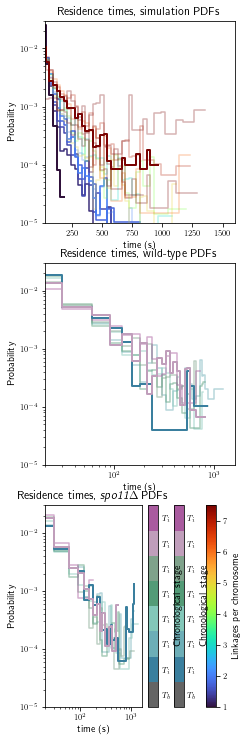

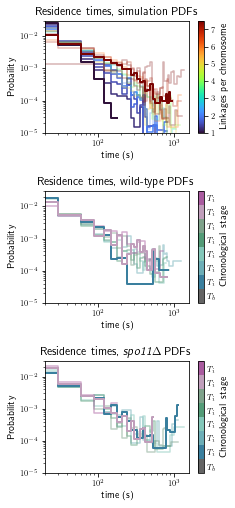

In [105]:
fig5ace, fig5ace_heights = bplt.make_at_aspect(
    [fig5c,
     partial(fig5abcd, strain=('LYS2', 'WT'), pair='pair'), 
     partial(fig5abcd, strain=('LYS2', 'SP'), pair='pair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
# fig5ace.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/Figure5ace-usetex.svg')

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],
/home/bbeltr1/developer/bruno_util/bruno_util/plotting.py:270: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  preprint = fig.canvas.print_svg(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0],

[0, 5]
found bold line: t0
found bold line: t5
[0, 5]
found bold line: t0
found bold line: t5


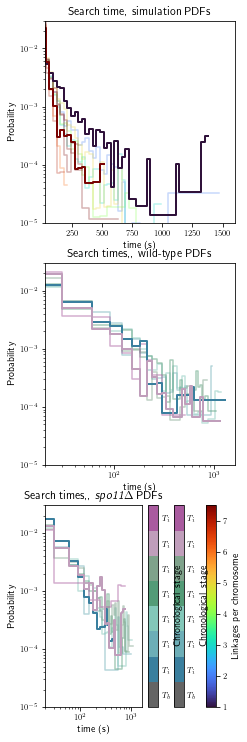

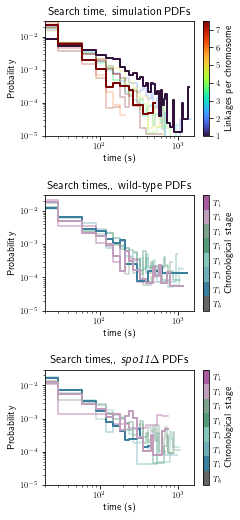

In [106]:
fig5bdf, fig5bdf_heights = bplt.make_at_aspect(
    [fig5f,
     partial(fig5abcd, strain=('LYS2', 'WT'), pair='unpair'), 
     partial(fig5abcd, strain=('LYS2', 'SP'), pair='unpair')],
    3*[1/golden_ratio], col_width, hspace=0.15,
    tight_width='bbox', halign=3*['min_axis_width'],
    is_ratio=True
)
fig5bdf.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/Figure5bdf-usetex.svg')

## Supplemental Figure XX

## Supplemental Figure YY

## Supplemental Figure -- "Transient" (Un)paired Times

In [46]:
is_30 = interior_df.reset_index().set_index(['wait_state'] + burgess.condition_cols)
is_30 = is_30['wait_time'] == 30
p30 = is_30.groupby(['wait_state'] + burgess.condition_cols).agg(['mean', 'std', 'count'])
cell_count = interior_df.reset_index().groupby(['wait_state'] + condition_cols)['cell'].unique().apply(len)
p30['cell_count'] = cell_count
p30['ste'] = p30['std']/np.sqrt(p30['cell_count'])
def suppfig_6a(ax):
    plot_fracs_large(p30.loc['pair'], ax)
    ax.set_title('Fraction of interaction times that are fast')
    return ax
def suppfig_6b(ax):
    plot_fracs_large(p30.loc['unp'], ax)
    ax.set_title('Fraction of search times that are fast')


In [47]:
def plot_fracs_large(fracs, ax=None):
    strains = ['URA3', 'LYS2']
    genotypes = ['WT', 'SP']
    for strain in strains:
        for genotype in genotypes:
            data = fracs.loc[strain, genotype]
            data = data.reset_index()
            m_to_t = lambda x: -1 if x[1] == 'a' else int(x[1])
            data['t'] = data['meiosis'].apply(m_to_t)
            data.sort_values('t', inplace=True)
            marker = 'x' if strain == 'LYS2' else 'o'
#             marker = 'X' if genotype == 'SP' else 'o'
            linestyle = '-' if strain == 'URA3' else '--'
#             linestyle = '-' if genotype == 'WT' else '--'
            fill = 'full' if strain == 'URA3' else 'none'
#             fill = 'full' if genotype == 'WT' else 'none'
            c = 'k' if genotype == 'WT' else 'r'
#             c = 'k' if strain == 'URA3' else 'r'
            markersize = 8  # if strain == 'LYS2' else 4
            markeredgewidth = 3 if strain == 'LYS2' else 2
            
            if ax is None:
                ax = plt
            ax.errorbar(data['t'], data['mean'], data['std']/np.sqrt(data['cell_count']),
                         linestyle=linestyle, c=c, linewidth=2, 
                         markersize=markersize, markeredgewidth=markeredgewidth,
                         marker=marker, fillstyle=fill,
                         label=r'($\it{' + str(strain) + '}$, ' + str(genotype) + ')')
    ax.set_xlabel('Chron. stage ($t_\#$)')
    #         plt.errorbar(data['t'], data['mean'], label='(' + str(strain) + ', ' + str(genotype) + ')')  

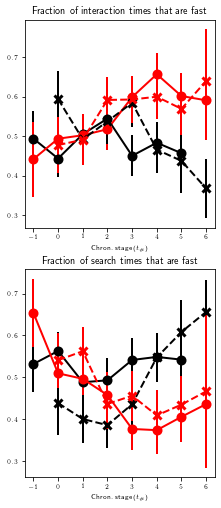

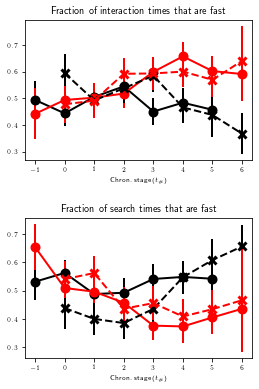

In [48]:
bplt.make_at_aspect([suppfig_6a, suppfig_6b], 2*[1/golden_ratio], col_width, 
        tight_width='bbox', hspace=0.15, halign=['full', 'full'],
        is_ratio=True)
plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-05-19-pnas/SuppFig_p30.svg')

## Chromosome size vs CO count

In [56]:
chr_info = pd.DataFrame([[1, 230218, 2.2],
                         [2, 813184, 6.4],
                         [3, 316620, 3.4],
                         [4, 1531933, 10.2],
                         [5, 576874, 4.45],
                         [6, 270161, 2.65],
                         [7, 1090940, 8.25],
                         [8, 562643, 4.65],
                         [9, 439888, 3],
                         [10, 745751, 6.5],
                         [11, 666816, 5.25],
                         [12, 1078177, 8.65],
                         [13, 924431, 7.25],
                         [14, 784333, 6.4],
                         [15, 1091291, 7.75],
                         [16, 948066, 7.45],
                        ], columns = ['Chromosome', 'Length', 'COs'])

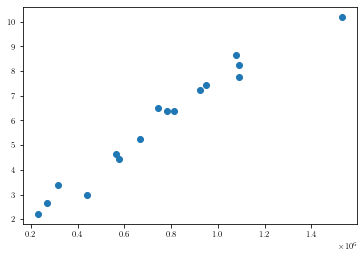

In [57]:
plt.scatter(chr_info['Length'], chr_info['COs'])

## Old color code

In [ ]:
## less old color code, but colormath is broken AF
# def bruno_div_map(n, left_lab, right_lab, midpoint_l, target_l=None):
#     illuminant = left_lab.illuminant
#     if illuminant != right_lab.illuminant:
#         raise ValueError("Must work with same illuminant!")
#     left_l = left_lab.lab_l if target_l is None else target_l
#     right_l = right_lab.lab_l if target_l is None else target_l
#     t = np.linspace(0, 1, n)
#     lab_a = np.interp(t, [0, 1], [left_lab.lab_a, right_lab.lab_a])
#     lab_b = np.interp(t, [0, 1], [left_lab.lab_b, right_lab.lab_b])
#     lab_l = np.interp(t, [0, 1/2, 1], [left_l, midpoint_l, right_l])
#     return [LabColor(lab_l[i], lab_a[i], lab_b[i]) for i in range(n)]




# # # OLD COLOR CODE
# # helper functions for makign color scheme
# def bruno_div_map(start_hue, start_sat, end_hue, end_sat, 
#                   target_lightness, interior_lightness, n):
#     # move linearly through hue space
#     hues = np.linspace(start_hue, end_hue, n)
    
#     # keep saturation constant on each side
#     sats = start_sat*np.ones_like(hues)
#     sats[int(n/2):] = end_sat
    
#     # lightness increase then decrease linearly
#     lights = np.ones_like(hues)
#     # +1 to peak lightness at odd center, if it exists
#     num_left = int(n/2) + 1 if n % 2 == 1 else int(n/2)
#     # run the following code to see that the lhs array indexers correctly split the array up
#     # for n in [4, 5]: # outputs 3,3 (half including middle) then 2,2 (half, no middle exists)
#     #     print(len(np.ones(n)[int(n/2):]))
#     #     print(len(np.ones(n)[:int(n/2)]))
#     lights[:num_left] = np.linspace(target_lightness, interior_lightness, num_left)
#     # to see that the 
#     lights[int(n/2):] = np.flip(lights[:num_left])
    

#     return np.array([hues, lights, sats]).T

# # colors we're interpolating between
# target_hues = [0.5609245293072375, 0.38810327170846054, 0.9319484879782322]
# target_saturations = [0.45, 0.35, 0.45]
# min_lightness = 0.4
# max_lightness = 0.7
# # before interpolating, useful to save actual values for later
# color_early, color_mid, color_late = [colorsys.hls_to_rgb(target_hues[i], target_saturations[i], min_lightness) for i in range(3)]
# blended_divs = np.concatenate((
#     bruno_div_map(target_hues[0], target_saturations[0],
#               target_hues[1], target_saturations[1],
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1500),
#     bruno_div_map(target_hues[1], target_saturations[1],
#               target_hues[2], target_saturations[2],
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1060)[1:]
# ))
# bgr = np.array([colorsys.hls_to_rgb(*hls) for hls in blended_divs])
# dark_blended_divs = np.concatenate((
#     bruno_div_map(target_hues[0], target_saturations[0]*0.7,
#               target_hues[1], target_saturations[1]*0.7,
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1500),
#     bruno_div_map(target_hues[1], target_saturations[1]*0.7,
#               target_hues[2], target_saturations[2]*0.7,
#               target_lightness=min_lightness, interior_lightness=max_lightness,
#               n=1060)[1:]
# ))
# bgr_dark = np.array([colorsys.hls_to_rgb(*hls) for hls in dark_blended_divs])

## How to size multiple axes AND figure correctly

Of course, the total width of the figure is set by the column width (which you should extract from LaTeX, as seen on `https://www.bastibl.net/publication-quality-plots/`_.

For example you could use the following code, where `placeholder.pdf` is any old image file (`.jpg`/`.png` will also work)::

    \begin{figure}
        \includegraphics[width=\columnwidth]{placeholder}
        \caption{This is a placeholder to measure the width of a plot. Its with is set to \texttt{columnwidth}.}
    \end{figure}
    
if you then open this file in Illustrator or Inkscape, you can extract the real width (in inches) of this placeholder to get `col_width`, which we will be expressing everything else here in terms of. 



Now, you have to specify the aspect ratio of each actual axis in your figure. For images, for example, you can grab the aspect ratio from the image object:

In [63]:
im = Image.open('extracted-progression-diagram.png')
im_height_ratio = im.height/im.width
im_height_ratio

0.2842430484037075

once you have all the ratios, you might think you can just do this:

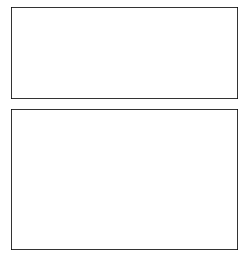

In [69]:
# figure size parameterization
text_space = 0.0*col_width
ax_height_1a = 0.4*col_width
spacing = 0.05*col_width
ax_height_1b = (1/golden_ratio)*col_width
fig_height = text_space + ax_height_1a + spacing + ax_height_1b
fig1 = plt.figure(figsize=(col_width,fig_height))
# [left, bottom, width, height]
ax1a = fig1.add_axes([0, (ax_height_1b+spacing)/fig_height, 1, ax_height_1a/fig_height],
                     xticks=[], yticks=[])
# ax1a.axis('off')
ax1b = fig1.add_axes([0, 0, 1, ax_height_1b/fig_height],
                     xticks=[], yticks=[])


or more in general

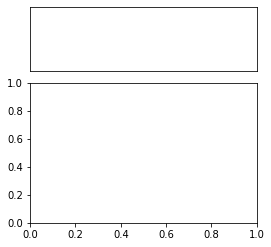

In [81]:
# col_width = # set above
intended_ratios = [im_height_ratio, 1/golden_ratio]
ax_args = [{'frameon': True, 'xticks': [], 'yticks': []}, {}]
spacing_ratio = 0.05
# the final bboxes we want for each axis object (complete with its labels/annotations)
super_ax_bboxs = []
total_ratio = np.sum(intended_ratios) + spacing_ratio*(len(intended_ratios) - 1)
cur_y = total_ratio
for height_ratio in intended_ratios:
    cur_y -= height_ratio
    super_ax_bboxs.append([0, cur_y/total_ratio, 1, height_ratio/total_ratio])
    cur_y -= spacing_ratio

fig = plt.figure(figsize=(col_width, col_width*total_ratio))
axs = [fig.add_axes(bbox, **ax_args[i]) for i, bbox in enumerate(super_ax_bboxs)]

plt.savefig('/home/bbeltr1/Downloads/ax_spacing.pdf')

getting the extents of these axes boxes in inkscape gives

In [71]:
bbox_a = [0, 201.933, 302.281, 201.933+85.922]
bbox_b = [0, 0.001, 302.281, 186.818]

In [72]:
intended_ratios

[0.2842430484037075, 0.6180339887498948]

In [73]:
85.922/302.281

0.2842454537334467

In [74]:
186.818/302.281

0.6180275968387031

so the axes are the right size, and I'm getting the correct amount of whitespace in between them "real" figure size (where the extra width measured in illustrator is because the ticks survive even though they go off the page)

In [75]:
bbox_actual = [-4.667, 0.001, 306.948, 288.388]

In [77]:
fig_height/col_width

1.0680339887498949

In [78]:
306.948/302.281

1.0154392766994949

but while these axes have the right aspect ratio right now, as soon as we add ticks or annotations, they will overflow over the edge of our figure. 

Fine, what if we ignore this for now and make the full figure?

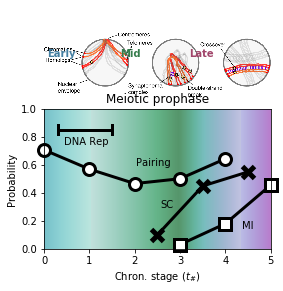

In [107]:
# col_width = # set above
intended_ratios = [im_height_ratio, 1/golden_ratio]
ax_args = [{'frameon': False, 'xticks': [], 'yticks': []}, {}]
spacing_ratio = 0.05
# the final bboxes we want for each axis object (complete with its labels/annotations)
super_ax_bboxs = []
total_ratio = np.sum(intended_ratios) + spacing_ratio*(len(intended_ratios) - 1)
cur_y = total_ratio
for height_ratio in intended_ratios:
    cur_y -= height_ratio
    super_ax_bboxs.append([0, cur_y/total_ratio, 1, height_ratio/total_ratio])
    cur_y -= spacing_ratio

fig = plt.figure(figsize=(col_width, col_width*total_ratio))
axs = [fig.add_axes(bbox, **ax_args[i]) for i, bbox in enumerate(super_ax_bboxs)]

fig1a(axs[0])
fig1b(axs[1])

plt.subplots_adjust()

plt.savefig('/home/bbeltr1/Documents/work/ajspakow/burgess/figures/2020-02-25-pnas/fig1-meiotic-progression.pdf', dpi=300, bbox_inches='tight')

This "looks" correct. And the aspect ratios we requested are there. However, instead of shrinking the axes to make it fig in the originally requested `figsize`, matplotlib simply increases the figure `bbox` to larger than we had originally requested. If we tried to use this figure, we'd have to shrink it to make it fit! (which would mean our carefully chosen text sizes wouldn't match anymore!)

Removing `bbox_inches='tight'` leaves us with the xticks cut off instead, even if we call `subplots_adjust` (since we didn't use subplots). If we want heterogeneously-spaced subplots, we're going to have to place and size them correctly ourselves....

.. warning::
    
    the following plot APPEARS correct when made in Jupyter (presumedly due to some `%matplotlib inline` magic, where bbox_layout='tight' is automatically used before saving to tmp file before displaying figure in notebook), but when saved by us, this figure is, in fact, cut off.

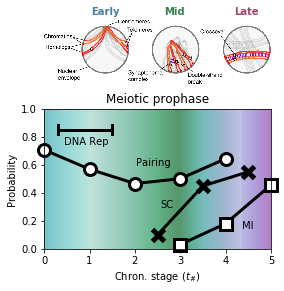

In [143]:
# figure size parameterization
text_space = 0.0*col_width
ax_height_1a = 0.4*col_width
spacing = 0.05*col_width
ax_height_1b = (1/golden_ratio)*col_width
fig_height = text_space + ax_height_1a + spacing + ax_height_1b
fig1 = plt.figure(figsize=(col_width,fig_height))
# [left, bottom, width, height]
ax1a = fig1.add_axes([0, (ax_height_1b+spacing)/fig_height, 1, ax_height_1a/fig_height],
                     frameon=False, xticks=[], yticks=[])
# ax1a.axis('off')
ax1b = fig1.add_axes([0, 0, 1, ax_height_1b/fig_height])

fig1a(ax1a)
fig1b(ax1b)

plt.subplots_adjust()
plt.savefig('/home/bbeltr1/Downloads/test-sp-adjust.pdf', dpi=300)

This is not what we want. I've previously used `plt.tight_layout()` with great success. However, this and `bbox_inches='tight'` are not equivalent. The former scales axes down to fit in figure box, while the latter scales figure up.

So what we really want is to use the subplots interface (intead of adding axes manually) so that we can just call `plt.tight_layout()`.

Thankfully, apparently there's a hidden gem: `Gridspec <https://matplotlib.org/3.1.1/tutorials/intermediate/gridspec.html>`_ that makes the subplots interface actually flexible enough to be useful!

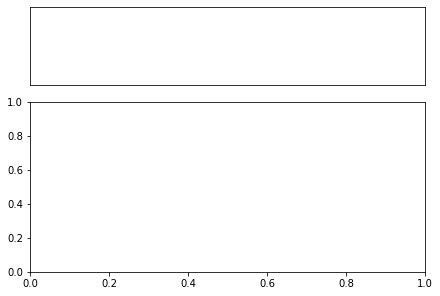

In [139]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_aspect = im.height/im.width

fig1 = plt.figure(constrained_layout=True)
# absolute size doesn't matter, only ratio
widths = [1]
heights = [im_aspect, 1/golden_ratio]
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


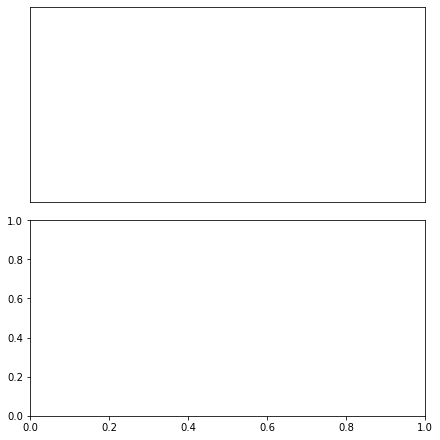

In [158]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_aspect = im.height/im.width

fig1 = plt.figure(constrained_layout=True, figsize=(6,6))
# absolute size doesn't matter, only ratio
widths = [1]
# heights = [im_aspect, 1]
heights = [1, 1]
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


# fig1a(ax1a)
# fig1b(ax1b)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

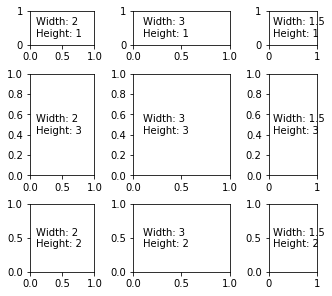

In [13]:
fig5 = plt.figure(constrained_layout=True)
widths = [2, 3, 1.5]
heights = [1, 3, 2]
spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
for row in range(3):
    for col in range(3):
        ax = fig5.add_subplot(spec5[row, col])
        label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')
plt.savefig('/home/bbeltr1/Downloads/test.pdf')

In [6]:
def example_plot(ax, fontsize=12, nodec=False):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    if not nodec:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    else:
        ax.set_xticklabels('')
        ax.set_yticklabels('')


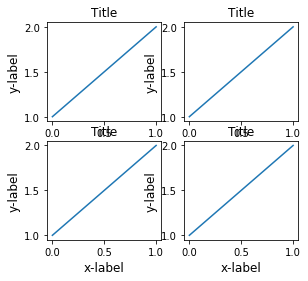

In [11]:
fig, axs = plt.subplots(2, 2, constrained_layout=False)
for ax in axs.flat:
    example_plot(ax)

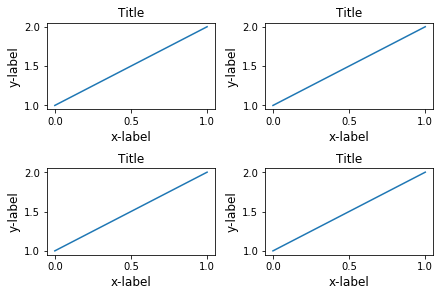

In [15]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
for ax in axs.flat:
    example_plot(ax)

In [106]:
# crap, looks like tutorial does this to misleading make it look better than it actually is at conserving aspect ratio

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np


plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 6, 4



fuck. nope. doesn't preserve aspect ratio.....

looks like I have to write my own engine to make figure logically remain in correct orientation given fixed width(/height) constraint!!!

it seems like vaguely, what we want to do, is to make our plot (independently of final figure size), then figure out what the axes extents are in that (oversized) figure w.r.t. to the final figure size, to account for text/labels/etc., then go back and remake figure with that information in hand.....

of course when we go back and remake the figure with "smaller" axes, the text will stay the same absolute size (so will be larger relative to the axes), and we may have to repeat this process to converge on the correct axes sizes :/....

If i were implemneting this in mainline, maybe I would call it `constrained_layout='horizontal'` or something.

In [47]:
orig_canvas = fig1.canvas
fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                      orientation='portrait', dryrun=True)
renderer = fig1._cachedRenderer
bbox_inches = fig1.get_tightbbox(renderer)

In [103]:
fig1.get_tightbbox?

In [61]:
bbox_inches.bounds

(-0.5080295138888888,
 -0.43988715277777773,
 3.7401228472222217,
 3.8028698551938964)

In [90]:
fig1.axes[0].get_position()

Bbox([[0.0, 0.6254800837675687], [1.0, 0.9999999999999999]])

In [99]:
fig1.transFigure.transform(fig1.axes[0].get_position())

array([[  0.        , 151.45046657],
       [226.71072   , 242.13475457]])

In [105]:
fig1.bbox.bounds

(0.0, 0.0, 226.71071999999998, 242.13475457396055)

In [104]:
fig1.bbox_inches.bounds

(0.0, 0.0, 3.14876, 3.3629827024161187)

cool, figured out how to get this stupid thing to give me reasonable bbox that I can compare to the axes positions

In [64]:
plt.figure?

but wait, have even more clever strategy now. 

First, make figure with constrained axes as above. won't work, but all we care about is how much space we have between axes (which doesn't depend on aspect ratio) and the absolute width of the axes. then we can use these to set the aspect ratio ourselves.

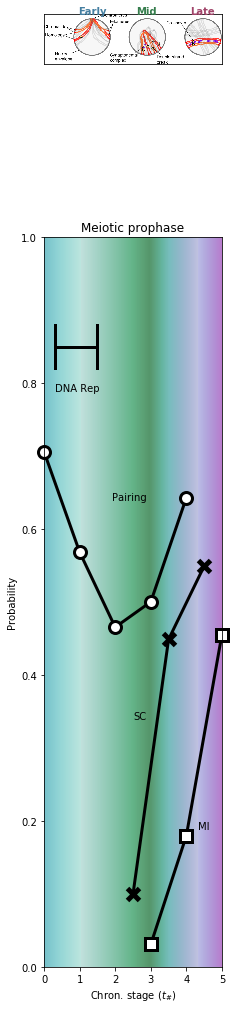

In [148]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

fig1 = plt.figure(constrained_layout=True, figsize=(col_width,  5*col_width))
# absolute size doesn't matter, only ratio
widths = [1]
heights = intended_ratios
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


fig1a(ax1a)
fig1b(ax1b)

# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

gotta be careful with constrained_layout for this, cause it may adjust the width in ways I don't understand depending in initial ("test") figure size

/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:27: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/home/bbeltr1/.miniconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


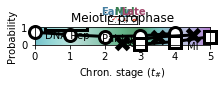

In [150]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

fig1 = plt.figure(constrained_layout=True, figsize=(col_width,  col_width/6))
# absolute size doesn't matter, only ratio
widths = [1]
heights = intended_ratios
spec1 = fig1.add_gridspec(ncols=1, nrows=2, width_ratios=widths,
                          height_ratios=heights)
rowa = 0; rowb = 1; col = 0;
ax1a = fig1.add_subplot(spec1[rowa, col], frameon=True, xticks=[], yticks=[])
ax1b = fig1.add_subplot(spec1[rowb, col])


fig1a(ax1a)
fig1b(ax1b)

# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

instead, use regular subplots...just make sure to leave more than enough room to get max possible width for each figure

In [128]:
plt.subplots?

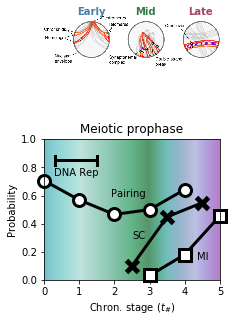

In [7]:
# for images, we must first extract target aspect ratio
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
intended_ratios = [im_height_ratio, 1/golden_ratio]

# leave a 2x margin of error for extra labels, etc.
test_fig_height = 2*np.sum(intended_ratios)*col_width

fig1, (ax1a, ax1b) = plt.subplots(nrows=2, figsize=(col_width, test_fig_height))
ax1a.axis('off')

fig1a(ax1a)
fig1b(ax1b)


# orig_canvas = fig1.canvas
# fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
# preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
#                       orientation='portrait', dryrun=True)
# renderer = fig1._cachedRenderer
# bbox_inches = fig1.get_tightbbox(renderer)

plt.savefig("/home/bbeltr1/Downloads/test.pdf")

In [196]:
# in figure "inches" units (fig.dpi_scale_trans)
fig1.get_tightbbox(fig1.canvas.renderer).bounds

(-0.11855777777777783,
 0.2241523497658336,
 3.035775111111111,
 4.252129113085017)

In [197]:
# in "figure pixel" units....is this IdentityTransform??...assume so for now
ax1a.get_tightbbox(fig1.canvas.renderer)

Bbox([[28.338839999999998, 264.84761871599244], [204.039648, 322.2922653252612]])

In [156]:
# in "figure" units (0,1) (fig.transFigure)
ax1a.get_position()

Bbox([[0.125, 0.647372304688804], [0.9, 0.769445877129378]])

seems like this is in display units....

In [159]:
fig1.transFigure.inverted().transform(ax1a.get_tightbbox(renderer))

array([[0.125     , 0.6473723 ],
       [0.9       , 0.78717432]])

In [160]:
fig1.dpi_scale_trans.inverted().transform(ax1a.get_tightbbox(renderer))

array([[0.393595  , 3.67843915],
       [2.833884  , 4.47280924]])

In [162]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform(ax1a.get_position())
)

array([[0.393595  , 3.67843915],
       [2.833884  , 4.37207433]])

In [166]:
Out[162][1] - Out[162][0]

array([2.440289  , 0.69363518])

In [167]:
Out[160][1] - Out[160][0]

array([2.440289  , 0.79437009])

In [168]:
fig1.dpi_scale_trans.inverted().transform(ax1b.get_tightbbox(renderer))

array([[-0.11443451,  0.27037631],
       [ 2.91721733,  2.87032895]])

In [169]:
Out[168][1] - Out[168][0]

array([3.03165185, 2.59995264])

In [172]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform([1,1])
)

array([3.14876   , 5.68210769])

In [182]:
fig1.dpi_scale_trans.inverted().transform(
    fig1.transFigure.transform(ax1b.get_position())
)

array([[0.393595  , 0.71026346],
       [2.833884  , 2.66025951]])

In [191]:
t = fig1.dpi_scale_trans.inverted() + fig1.transFigure

In [192]:
t.transform(ax1b.get_position())

array([[0.393595  , 0.71026346],
       [2.833884  , 2.66025951]])

In [183]:
Out[182][0,0] - (-0.11443451388888894)

0.5080295138888888

In [186]:
ax1b.get_axes_locator() is None

True

In [198]:
[t.transform(ax.get_position()) for ax in fig1.axes]

[array([[0.393595  , 3.67843915],
        [2.833884  , 4.37207433]]), array([[0.393595  , 0.71026346],
        [2.833884  , 2.66025951]])]

In [200]:
[fig1.dpi_scale_trans.inverted().transform(ax.get_tightbbox(fig1.canvas.renderer)) for ax in fig1.axes]


[array([[0.393595  , 3.67843915],
        [2.833884  , 4.47628146]]), array([[-0.11855778,  0.22415235],
        [ 2.91721733,  2.88248173]])]

In [201]:
fig1.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig1)
preprint = fig1.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                      orientation='portrait', dryrun=True)
renderer = fig1._cachedRenderer

In [202]:
[fig1.dpi_scale_trans.inverted().transform(ax.get_tightbbox(renderer)) for ax in fig1.axes]


[array([[0.393595  , 3.67843915],
        [2.833884  , 4.47280924]]), array([[-0.11443451,  0.27037631],
        [ 2.91721733,  2.87032895]])]

okay, now the generalized code

In [5]:
import numbers
import io
def make_at_aspect(plot_funcs, height_ratios, col_width,  tight_width='bbox', hspace=None, halign=None, **kw_figs):
    """Get figure with fixed column width and requested aspect ratios per subplot.
    
    Parameters
    ----------
    plot_funcs : Sequence[Callable[[matplotlib.axes.Axes], None]]
        function to create each subplot given the axes to draw it into
    height_ratios : Sequence[float]
        height/width ratio desired for each subplot. single number is allowed for
        fixed aspect ratio across all axes
    col_width : float
        absolute width of figure desired, in inches
    tight_width : string
        'bbox' or 'tight'. 'bbox' means use default generated by bbox_inches='tight'. 'tight' 
        means to actually remove all whitespace from left and right size of final figure
    hspace : float
        vertical space between adjacent axes bboxes as fraction of average axis height 
        (not fraction of average axis bbox height). defaults to value in rc.
    halign : Sequence[string]
        either 'full' or 'min_axis_width' for each subplot. defaults to all 'min_axis_width'
    
    
    Returns
    -------
    ax : matplotlib.figure.Figure
        the final figure
        
    Notes
    -----
    No extra "axes_kw" argument is provided, since each axis is passed to it's appropriate 
    plot_func, which should be able to set any relevant extra parameters for that axis.
    """
    n_plots = len(plot_funcs)
    if halign is None:
        halign = n_plots * ['min_axis_width']
    try:
        if n_plots != len(height_ratios):
            raise ValueError("length of height_ratios and plot_funcs should match")
    except TypeError: # no __len__
        if not isinstance(height_ratios, numbers.Number):
            raise ValueError("height_ratios should be list of ratios or single float")
        # we have a single number, simply tile it accordingly
        height_ratios = n_plots*[height]
    
    # first make "test" figure to get correct extents including all labels, etc
    # leave a 2x margin of error for the labels to fit into vertically.
    test_fig_height = 2*np.sum(height_ratios)*col_width
    fig, axs = plt.subplots(nrows=n_plots, figsize=(col_width, test_fig_height), **kw_figs)
    for i in range(n_plots):
        plot_funcs[i](axs[i])
    
    # "dry-run" a figure save to get "real" bbox for full figure with all children
    fig.canvas = mpl.backends.backend_pdf.FigureCanvasPdf(fig)
    preprint = fig.canvas.print_pdf(io.BytesIO(), dpi=300, facecolor=[1,1,1], edgecolor=[0,0,0], 
                          orientation='portrait', dryrun=True)
    #TODO: which is right? neither seem exactly right according to inkscape?
    # if we use fig.canvas.renderer instead, we get different answers o.o
    renderer = fig._cachedRenderer
    disp_to_inch = fig.dpi_scale_trans.inverted()
    fig_to_inch = fig.dpi_scale_trans.inverted() + fig.transFigure

    # now get extents of axes themselves and axis "bbox"s (i.e. including labels, etc)
    ax_bbox_inches = []
    ax_inches = []
    for ax in axs:
        ax_bbox = ax.get_tightbbox(renderer) # docs say in "figure pixels", but means "display"
        ax_bbox_inches.append(disp_to_inch.transform(ax_bbox))
        ax_inches.append(fig_to_inch.transform(ax.get_position())) 
    x0s, y0s, x1s, y1s = map(np.array, zip(*map(np.ndarray.flatten, ax_bbox_inches)))
    ax0s, ay0s, ax1s, ay1s = map(np.array, zip(*map(np.ndarray.flatten, ax_inches)))
  
    # get final horizontal size of figure
    if tight_width == 'bbox':
        bbox_inches = fig.get_tightbbox(renderer).bounds
        real_h_extents = [bbox_inches[0], bbox_inches[2]]
        real_v_extents = [bbox_inches[1], bbox_inches[3]]
    elif tight_width == 'tight':
        real_h_extents = [np.min(x0s), np.max(x1s)]
        real_v_extents = [np.min(y0s), np.max(y1s)]
    
    # calculate space required in addition to axes themselves
    pads_left = ax0s - x0s
    pads_right = x1s - ax1s
    pads_above = y1s - ay1s
    pads_below = ay0s - y0s
    max_pad_left = np.max(pads_left)
    max_pad_right = np.max(pads_right)
    
    # get axes sizes
    x0 = np.zeros(n_plots)
    x1 = np.zeros(n_plots)
    height = np.zeros(n_plots)
    for i in range(n_plots):
        if halign[i] == 'full':
            x0[i] = pads_left[i]
            x1[i] = col_width - pads_right[i]
        elif halign[i] == 'min_axis_width':
            x0[i] = max_pad_left
            x1[i] = col_width - max_pad_right
        else:
            raise ValueError(f"Invalid option passed for halign: {halign[i]}. Should be 'full' or 'min_axis_width'")
    height = height_ratios*(x1 - x0)
    if hspace is None:
        hspace = fig.subplotpars.hspace
    hspace = hspace*np.mean(height)
    
    # make new figure with axes "correctly" located
    total_height = np.sum(height) + np.sum(pads_below) + np.sum(pads_above) \
                + (n_plots - 1)*hspace
    fig = plt.figure(figsize=(col_width, total_height), **kw_figs)
    cur_y = 1 # track y pos normalized to height of figure
    for i in range(n_plots):
        left = x0[i]/col_width
        right = x1[i]/col_width
        cur_y -= pads_above[i]/total_height
        top = cur_y 
        cur_y -= height[i]/total_height
        bottom = cur_y
        cur_y -= pads_below[i]/total_height
        cur_y -= hspace/total_height
        ax = fig.add_axes([left, bottom, right-left, top-bottom])
        plot_funcs[i](ax)
#     import pdb; pdb.set_trace()
    return fig            

#NOTE: alternate bbox from pixels to inches:
# bbox_inches = TransformedBbox(bbox, Affine2D().scale(1 / fig.dpi)

In [1]:
im = Image.open("extracted-progression-diagram.png")
im_height_ratio = im.height/im.width
fig = make_at_aspect([fig1a, fig1b], [im_height_ratio, 1/golden_ratio], col_width,
                     tight_width='bbox', hspace=0.2, halign=['full', 'min_axis_width'])
plt.savefig('/home/bbeltr1/Downloads/test.pdf', dpi=300)

NameError: name 'Image' is not defined

cool, so that works, but requires a PR to matplotlib's upstream so that get_tightbbox works correctly

let's test that PR.